<a href="https://colab.research.google.com/github/guiattard/PythonForGeosciences/blob/master/exploring-hydro-geological-data-of-france-with-python/main-file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring (hydro-)geological data of France with python

by [Guilllaume Attard](https://guillaumeattard.com/)

http://pythonforgeosciences.com

(last update 26/11/2020)

Notebook status : *Under Review*

## Introduction

In France, main geological/geoscientific data are managed by the [French Geological Survey](https://www.brgm.fr/) and several plaforms provide a public and free access to many datasets such as:
- [geological maps](https://infoterre.brgm.fr/page/telechargement-cartes-geologiques).
- boreholes, piezometers and wells locations, geological reports and cross sections ([InfoTerre](https://infoterre.brgm.fr/viewer/MainTileForward.do)). In France, this database is known as the BSS (*Base de donnée du Sous-Sol*) which includes more than 700 000 boreholes descriptions.
- piezometric time series and physico-chemical analysis from the national monitoring network ([ADES](https://ades.eaufrance.fr/)).

These data dedicated to the (hydro-)geological knowledge are used by engineers and scientists to prevent natural risks and disasters (e.g. landslides or settlements), protect groundwater ressources and secure water supply for example. Particularly, these data can be used in many fields such as hydrogeology, geothermal energy and geotechnical applications.

These datasets can be explored and download manually by visiting the main platform of the french geological survey [InfoTerre](https://infoterre.brgm.fr/viewer/MainTileForward.do), but when it comes to export a large amout of data, at a regional scale, this task becomes tedious and time consuming. To face this problem, and improve the dissemination of geoscientific data to the public and to scientists, the french geological survey recently developped many geo-webservices in accordance with european open-data requirements. These geo-websercices can help to automate geological data manipulation, analysis and mapping.

Consequently, the aim of this article is to present some of these services. Particularly, we are going to:
- download and analyse boreholes informations at the scale of the department of our choice: water supply wells and geothermal installations will be identified.
- map all these hydrogeological information on an interactive folium map and add the geological tiles of France.
- play with two [Hubeau APIs](https://hubeau.eaufrance.fr/) to describe piezometric and physico-chemical characteristics of some groundwater wells: we will learn how to access and analyse hydaulic heads and groundwater quality fluctuations on the groundwater wells we want.

## Run me first

### Import usefull libraries

Before starting we need to install/import some libraries:

In [ ]:
!apt install gdal-bin python-gdal python3-gdal
!pip install fiona shapely pyproj
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install git+https://github.com/python-visualization/folium

In [7]:
import pandas as pd
import geopandas as gpd
import zipfile
import requests
import numpy as np
from pyproj import Transformer
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

### Administrative units of France

To download informations at the scale of a department, we need some a geographical dataset with administrative units of France. We can use the openstreetmap shapefile of french departements. We download this shapefile and put it in a local directory as follow:

In [8]:
# The url where we can fide the shapefile
url_dep = "http://osm13.openstreetmap.fr/~cquest/openfla/export/departements-20180101-shp.zip"

# The name of the zip file
file_dep = "departements-20180101-shp.zip"

# Command to donwload the file at the given url
r = requests.get(url_dep)

# Then we open the file
open(file_dep, 'wb').write(r.content)

# We extract the content of the .zip file
with zipfile.ZipFile(file_dep, 'r') as unzip: unzip.extractall("dep.shp")

# we finally read the shapefile and make some cleaning
dep = gpd.read_file("dep.shp")

# We remove the zipfile
os.remove(file_dep)

# we print the head of our geodataframe
dep.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La Réunion,FR940,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."


All department numbers are indicated in the column *code_insee*. We should be careful about this number because the *Rhône* departement is identified as 69D to make the difference with the metropolitan area of Lyon which is identified as 69M. Here, we do not want to distinguish them so we create a new column associating the same number *69*.

In [9]:
dep["num"] = dep["code_insee"]
dep = dep.set_index("code_insee")
dep.at["69M", "num"] = "69"
dep.at["69D", "num"] = "69"

### Selection of some departments of interest

To see the result, we can select some departments of intereset and preview their shape. In the following, we will work with this selection of departments numbers to get some (hydro-)geological information. I decide to work with the departement of the Ain (01), the Rhône (69) and of the Isère (38) but you can select others.

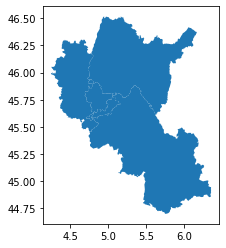

In [10]:
# We select the numbers (as strings) of our department of interest
deps_of_interest = ['69', '01', '38']

# We reduce our geodataframe to our departement of interest
dep = dep.loc[dep["num"].isin(deps_of_interest)]
dep.plot()

plt.show()

We also download a dataset of main cities of France (more than 100'000 inhabitants) and we keep the cities inside our depatment of interest following a similar procedure.

In [11]:
# The url where we can fide the shapefile cities
url_cit = "https://simplemaps.com/static/data/country-cities/fr/fr.csv"

# Same procedure as seen before for departments
file_cit = "fr.csv"

r = requests.get(url_cit)
open(file_cit, 'wb').write(r.content)

cit = pd.read_csv('fr.csv', encoding='utf-8')

#We convert it into a geodataframe
geo_cit = gpd.GeoDataFrame(cit, geometry = gpd.points_from_xy(cit.lng, cit.lat),
                           crs = 'epsg:4326')

#We only keep cities inside our dep of interest:
geo_cit = gpd.sjoin(geo_cit, dep, op='within')

# We sort the associated table by population:
geo_cit = geo_cit.sort_values(by=['population_proper'], ascending = False).dropna()

# we print the head of our geodataframe
geo_cit.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper,geometry,index_right,nom,nuts3,wikipedia,surf_km2,num
8,Lyon,45.7600,4.8400,France,FR,Auvergne-Rhône-Alpes,admin,516092.0,516092.0,POINT (4.84000 45.76000),69M,Métropole de Lyon,FR716,fr:Métropole de Lyon,538.0,69
5,Grenoble,45.1715,5.7224,France,FR,Auvergne-Rhône-Alpes,minor,687985.0,158454.0,POINT (5.72240 45.17150),38,Isère,FR714,fr:Isère (département),7878.0,38
165,Bourg-en-Bresse,46.2056,5.2289,France,FR,Auvergne-Rhône-Alpes,minor,41527.0,41527.0,POINT (5.22890 46.20560),01,Ain,FR711,fr:Ain (département),5784.0,01
256,Vienne,45.5242,4.8781,France,FR,Auvergne-Rhône-Alpes,minor,29306.0,29306.0,POINT (4.87810 45.52420),38,Isère,FR714,fr:Isère (département),7878.0,38


## Extraction and analysis of boreholes information (BSS data)

### Get your data into a clean (geo-)dataframe

Now, we want to get some information about the geological units of these departments. In the following, we are going to define a function that take the department number as input and which give a dataframe of boreholes information as output. Then, we will be able to identify we groundwater wells or geothermal installations are located and determine the groundwater table depth.

In [12]:
def download_bss_dep(num):
    # We use the URL where we can find all BSS zipfile sorted by department
    url_root = "http://infoterre.brgm.fr/telechargements/ExportsPublicsBSS/"
    file = "bss_export_" + num + ".zip"
    url = url_root + file
    
    # It will be the final path of our file
    final_path = "bss_export_" + num +".csv"
    
    if os.path.isfile(final_path):
        # If we have already download this BSS dep, no need to download it again
        print(file +" already exists. Remove it if an update is necessary.")
        bss = pd.read_csv(final_path, sep=';', decimal=",", low_memory=False)
    else:
        # We download the data and we reproduce the previous process
        print(file +" does not exist. Download in progress.")
        r = requests.get(url)
        open(file, 'wb').write(r.content)
        with zipfile.ZipFile(file, 'r') as unzip: unzip.extractall()
        print(file +" is now downloaded.")

        # We remove the zip
        os.remove(file)

        # We build the dataframe
        bss = pd.read_csv(final_path, sep=';', decimal=",", low_memory=False)
    return bss

Now we can make a loop to concat the data of our departments of interest:

In [13]:
# We create an empty dataframe
bss_dataset = pd.DataFrame()

# Our loop where we apply our function
for num_dep in deps_of_interest:
    bss = download_bss_dep(num_dep)
    frames = [bss_dataset,bss]
    bss_dataset = pd.concat(frames)
    print('Departement', num_dep, 'is done.')
    
bss_dataset.head()

bss_export_69.zip already exists. Remove it if an update is necessary.
Departement 69 is done.
bss_export_01.zip already exists. Remove it if an update is necessary.
Departement 01 is done.
bss_export_38.zip already exists. Remove it if an update is necessary.
Departement 38 is done.


,ID_BSS,indice,designation,nom_abrege,libelle,lien_infoterre,google_maps,coupe_geologique,coupe_autre,log_geol_verifie,nb_scans,nb_scans_coupe,lex_organisme,lex_type_declaration,point_eau,lex_sgr,lex_num_departement,lex_nom_departement,lex_num_commune,lex_insee_commune,lex_nom_commune,lieu_dit,x_saisie,y_saisie,lex_projection_saisie,lex_unite_saisie,x_ref06,y_ref06,lex_projection_ref06,lex_precision_xy,lex_qual_position,z_sol,lex_prec_z_sol,lex_mode_obtention_z,z_bdalti,lex_nature,prof_investigation,prof_accessible,diametre_tubage,prof_eau_sol,lex_type_prof_eau_sol,date_eau_sol,z_origine_coupe,lex_prec_z_origine_coupe,date_coupe,date_fin_travaux,nombre_observations,lex_num_carte_geol,lex_nom_carte_geol,coupure_huitieme,lex_etat_physique,lex_etat,lex_execution,lex_utilisation,lex_recherche,lex_exploitation,lex_reconnaissance,lex_fonction,deb_fonction,lex_usage,deb_usage,lex_gisement,lex_documents,reference,date_dossier,date_saisie,date_dern_maj,procede_geothermique,categorie_geothermie,usage_geothermie,relation_aquifere
0,BSS001PYDG,06246X0004,CPT,CPT,NaN,"=LIEN_HYPERTEXTE(""http://ficheinfoterre.brgm.f...","=LIEN_HYPERTEXTE(""http://maps.google.fr/?q=046...",Absente,Absente,Absent,3,0,BRGM,Hors Declaration,OUI,SGR/RHA,69,RHONE,002,69002,AIGUEPERSE,MERGANE 1,761625.,2142910.,Lambert 2 étendu,Mètre,810400,6575119,Lambert-93,NaN,BON,532.,MNT,NaN,NaN,FORAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,624,CLUNY,6X,NaN,EXPLOITE.,NaN,AEP.,NaN,EAU.,NaN,NaN,NaN,NaN,NaN,NaN,"ANALYSE-CHIMIQUE-EAU,PERIMETRE-PROTECTION,PLAN...",VOIR DOSSIER 06246X0003 (EAU DE MELANGE),NaN,03/12/2003,03/12/2003,NaN,NaN,NaN,NaN
1,BSS001PYDH,06246X0005,CPT,CPT,NaN,"=LIEN_HYPERTEXTE(""http://ficheinfoterre.brgm.f...","=LIEN_HYPERTEXTE(""http://maps.google.fr/?q=046...",Absente,Absente,Absent,4,0,BRGM,Hors Declaration,OUI,SGR/RHA,69,RHONE,002,69002,AIGUEPERSE,MERGAGNE 2,761542.,2142745.,Lambert 2 étendu,Mètre,810316,6574955,Lambert-93,NaN,BON,570.,MNT,NaN,571.,FORAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,624,CLUNY,6X,NaN,EXPLOITE.,NaN,AEP.,NaN,EAU.,NaN,NaN,NaN,NaN,NaN,NaN,"ANALYSE-CHIMIQUE-EAU,PERIMETRE-PROTECTION,PLAN...",VOIR DOSSIER 06246X0003 ET 0004,NaN,08/08/2003,08/08/2003,NaN,NaN,NaN,NaN
2,BSS001PYDJ,06246X0006,CPT,CPT,NaN,"=LIEN_HYPERTEXTE(""http://ficheinfoterre.brgm.f...","=LIEN_HYPERTEXTE(""http://maps.google.fr/?q=046...",Absente,Absente,Absent,3,0,BRGM,Hors Declaration,OUI,SGR/RHA,69,RHONE,002,69002,AIGUEPERSE,MERGAGNE 3,761.435,142.815,Lambert 2 - Centre,Kilomètre,810209,6575025,Lambert-93,NaN,BON,558.,MNT,NaN,566.,FORAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,624,CLUNY,6X,NaN,EXPLOITE.,NaN,AEP.,NaN,EAU.,NaN,NaN,NaN,NaN,NaN,NaN,"ANALYSE-CHIMIQUE-EAU,PERIMETRE-PROTECTION,PLAN...",VOIR DOSSIER 06246X0003 ET 0004,NaN,08/08/2003,08/08/2003,NaN,NaN,NaN,NaN
3,BSS001PYER,06248X0003,S,S,NaN,"=LIEN_HYPERTEXTE(""http://ficheinfoterre.brgm.f...","=LIEN_HYPERTEXTE(""http://maps.google.fr/?q=046...",Absente,Absente,Absent,4,0,BRGM,Code Minier,OUI,SGR/RHA,69,RHONE,035,69035,CENVES,ROUSSET,778.743,143.412,Lambert 2 - Centre,Kilomètre,827507,6575474,Lambert-93,NaN,BON,480.,EPD,NaN,493.,SOURCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPD,NaN,26/02/1975,NaN,624,CLUNY,8X,NaN,EXPLOITE.,NaN,AEP.,NaN,EAU.,NaN,NaN,NaN,NaN,NaN,NaN,"DOCUMENTATION-GEOLOGIQUE,PERIMETRE-PROTECTION,...",(1) VOIR DOSSIER 0624-8X-0004,01/09/1987,01/09/1987,22/07/2015,NaN,NaN,NaN,NaN
4,BSS001PYES,06248X0004,HY,HY,NaN,"=LIEN_HYPERTEXTE(""http://ficheinfoterre.brgm.f...","=LIEN_HYPERTEXTE(""http://maps.google.fr/?q=046...",Absente,Absente,Absent,3,0,BRGM,Code Minier,OUI,SGR/RHA,69,RHONE,035,69035,CENVES,PREMECIN,779.363,144.36,Lambert 2 - Centre,Kilomètre,828134,6576416,Lambert-93,NaN,BON,600.,EPD,NaN,616.,SOURCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPD,NaN,26/02/1975,NaN,624,CLUNY,8X,NaN,EXPLOITE.,NaN,AEP.,NaN,EAU.,NaN,NaN,NaN,NaN,NaN,NaN,"DOCUMENTATION-GEOLOGIQUE,PERIMETRE-PROTECTION,...",NaN,01/09/1987,01/09/1987,22/07/2015,NaN,NaN,NaN,NaN


As you can see, there are 71 columns: *'ID_BSS', 'indice', 'designation', 'nom_abrege', 'libelle', 'lien_infoterre', 'google_maps', 'coupe_geologique', 'coupe_autre', 'log_geol_verifie', 'nb_scans', 'nb_scans_coupe', 'lex_organisme', 'lex_type_declaration', 'point_eau', 'lex_sgr', 'lex_num_departement', 'lex_nom_departement', 'lex_num_commune', 'lex_insee_commune', 'lex_nom_commune', 'lieu_dit', 'x_saisie', 'y_saisie', 'lex_projection_saisie', 'lex_unite_saisie', 'x_ref06', 'y_ref06', 'lex_projection_ref06', 'lex_precision_xy', 'lex_qual_position', 'z_sol', 'lex_prec_z_sol', 'lex_mode_obtention_z', 'z_bdalti', 'lex_nature', 'prof_investigation', 'prof_accessible', 'diametre_tubage', 'prof_eau_sol', 'lex_type_prof_eau_sol', 'date_eau_sol', 'z_origine_coupe', 'lex_prec_z_origine_coupe', 'date_coupe', 'date_fin_travaux', 'nombre_observations', 'lex_num_carte_geol', 'lex_nom_carte_geol', 'coupure_huitieme', 'lex_etat_physique', 'lex_etat', 'lex_execution', 'lex_utilisation', 'lex_recherche', 'lex_exploitation', 'lex_reconnaissance', 'lex_fonction', 'deb_fonction', 'lex_usage', 'deb_usage', 'lex_gisement', 'lex_documents', 'reference', 'date_dossier', 'date_saisie', 'date_dern_maj', 'procede_geothermique', 'categorie_geothermie', 'usage_geothermie', 'relation_aquifere'*.

In the following, we reduce our focus to few relevent attributs (but please add more if you want to):
- *ID_BSS*, *indice* and *designation* which are national codes of boreholes. These codes are requested when making queries to different webservices (we'll see that later),
- *point_eau* is a bolean indicating if there is some groundwater or not,
- *x_ref06* and *y_ref06* are indicating the location in a geographical projection given by *lex_projection_ref06*,
- *z_sol* indicates the ground elevation mesured and *z_bdalti* the ground elevation given by the IGN at the same location (can be useful to get both to identify some errors),
- *prof_investigation* indicates the total depth of the borehole,
- *prof_eau_sol* indicates the groundwater table depth if any exists.
- *lex_usage* refer to the usage of the borehole/water well,
- *procede_geothermique*, *categorie_geothermie*, and *usage_geothermie* are indicating if the point is actually a geothermla installation.

In [14]:
items = ['ID_BSS', 'indice', 'designation', 'x_ref06', 'y_ref06','lex_projection_ref06','z_sol', 'z_bdalti', 'point_eau',
       'prof_investigation', 'prof_eau_sol', 'lex_usage', 'procede_geothermique',
       'categorie_geothermie', 'usage_geothermie']

# We reduce our dataframe to relevant items:
bss_dataset = bss_dataset[[col for col in items]]

# We need to recreate the "old" ID of boreholes to access some data (later)
bss_dataset['code_bss'] = bss_dataset['indice'] + '/' + bss_dataset['designation']
bss_dataset.head()

,ID_BSS,indice,designation,x_ref06,y_ref06,lex_projection_ref06,z_sol,z_bdalti,point_eau,prof_investigation,prof_eau_sol,lex_usage,procede_geothermique,categorie_geothermie,usage_geothermie,code_bss
0,BSS001PYDG,06246X0004,CPT,810400,6575119,Lambert-93,532.,NaN,OUI,NaN,NaN,NaN,NaN,NaN,NaN,06246X0004/CPT
1,BSS001PYDH,06246X0005,CPT,810316,6574955,Lambert-93,570.,571.,OUI,NaN,NaN,NaN,NaN,NaN,NaN,06246X0005/CPT
2,BSS001PYDJ,06246X0006,CPT,810209,6575025,Lambert-93,558.,566.,OUI,NaN,NaN,NaN,NaN,NaN,NaN,06246X0006/CPT
3,BSS001PYER,06248X0003,S,827507,6575474,Lambert-93,480.,493.,OUI,NaN,NaN,NaN,NaN,NaN,NaN,06248X0003/S
4,BSS001PYES,06248X0004,HY,828134,6576416,Lambert-93,600.,616.,OUI,NaN,NaN,NaN,NaN,NaN,NaN,06248X0004/HY


Because the projection is not the same for all departements of France (because of overseas departments), the epsg number of different projections must be known. They are listed in a *epsg* dataframe below and finally, a procedure is made to convert all location in longitudes/latitudes (epsg:4326). **The following step is required in case you want to work on overseas departments. In case you won't, the following procedure still works to get longitudes/latitudes from Lambert 93 coordinates**.

In [15]:
# We build a epsg df to associate projection names and epsg codes:
epsg_df = pd.DataFrame(columns = ['name', 'code_epsg'])
epsg_df = epsg_df.set_index('name')
epsg_df.at['Lambert-93', 'code_epsg'] = '2154'
epsg_df.at['Antilles-84-RRAF91', 'code_epsg'] = '32620'
epsg_df.at['Guyane-95', 'code_epsg'] = '2972'
epsg_df.at['Réunion-92', 'code_epsg'] = '2975'
epsg_df.at['Mayotte-2004', 'code_epsg'] = '4471'

# We create a longitude and latitude column to our dataset:
bss_dataset['long'] = ""
bss_dataset['lat'] = ""

# We make a loop through different projections to convert all in long/lat
for name in epsg_df.index:
    if name in set(bss_dataset['lex_projection_ref06'].dropna()):
        code = epsg_df.at[name, 'code_epsg']
        
        # This is the input projection name
        inProj = 'epsg:' + code
        
        # This is the output projection name
        outProj = 'epsg:4326'

        # We get the X and Y data
        x = np.asanyarray(bss_dataset.loc[bss_dataset['lex_projection_ref06'] == name]['x_ref06'])
        y = np.asanyarray(bss_dataset.loc[bss_dataset['lex_projection_ref06'] == name]['y_ref06'])
        
        # We define the transformer
        transformer = Transformer.from_crs(inProj, outProj)
        
        # We apply the transformer
        latitude ,longitude = transformer.transform(x, y)
        
        # We add the long/lat info to the dataframe
        bss_dataset.loc[bss_dataset['lex_projection_ref06'] == name, 'long'] = longitude
        bss_dataset.loc[bss_dataset['lex_projection_ref06'] == name, 'lat'] = latitude
    else:
        continue

# we remove lines where longitudes/latitudes are empty :
bss_dataset = bss_dataset.loc[(bss_dataset['long'] != '') &
                              (bss_dataset['lat'] != '')]

#Finally we can convert our dataframe into a geodataframe
geo_bss = gpd.GeoDataFrame(bss_dataset, 
                           geometry=gpd.points_from_xy(bss_dataset.long, bss_dataset.lat),
                           crs = 'epsg:4326')

In practice, there are some errors in the reporting of points coordinates so to remove these errors, we make a spatial join of our geodataframe with the spatial extent of our department of interest: we only keep points inside our departments. Finally we plot the location of boreholes.

In [16]:
# We make some cleaning by removing points which are outside our departments of interest
geo_bss = gpd.sjoin(geo_bss, dep, op='within')

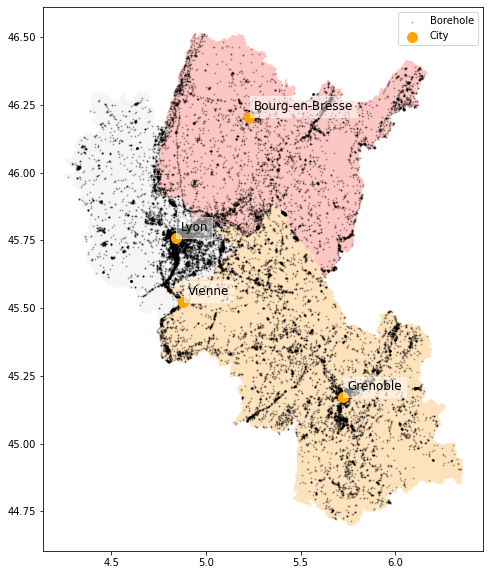

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

# We plot our deps of interest with the Pastel 1 colormap
dep.plot(ax = ax, column = "num", cmap = "Pastel1", alpha = 0.75)

# We add the location of borehole in black
geo_bss.plot(ax =ax, color = "black", markersize=1, label = "Borehole", alpha = 0.25)

# We add 5 main cities
main_cities = geo_cit.head(5)
main_cities.plot(ax =ax, color = "orange", marker = 'o', markersize=100, label = 'City')

# We add some cities to our map
for idx, row in main_cities.iterrows():
    txt = plt.annotate(s=row['city'], 
                 xy=[row['geometry'].x +0.025, row['geometry'].y +0.025],
                 horizontalalignment='left',
                 color = 'black',
                 backgroundcolor="w",
                 fontsize = 12)
    
    txt.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))

plt.legend()
plt.show()

We can of course save our geodataframe as a shapefile, in a RESULTS folder as follow:

In [18]:
dir_res = './RESULTS'
try:
# Create target Directory
    os.mkdir(dir_res)
except FileExistsError:
    pass
print("The folder is now created")

geo_bss.to_file("./RESULTS/all_boreholes.shp")
print("The file is saved")

The folder is now created


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  if __name__ == '__main__':


The file is saved


### Identifying groundwater wells and geothermal installations

Of course we can decide to distinguish the kind of borehole we want to keep. For example, let's select (1) boreholes where a groundwater table depth is reported and (2) geothermal installations.

In the first case, we keep points where the attribute *point_eau* is *OUI* (meaning that there is some groundwater right here) AND where *prof_eau_sol* is not a NaN value (meaning that we should know the groundwater table depth).

In the second case, we keep points where *categorie_geothermie* OR *procede_geothermique* OR *usage_geothermie* is not a NaN value.

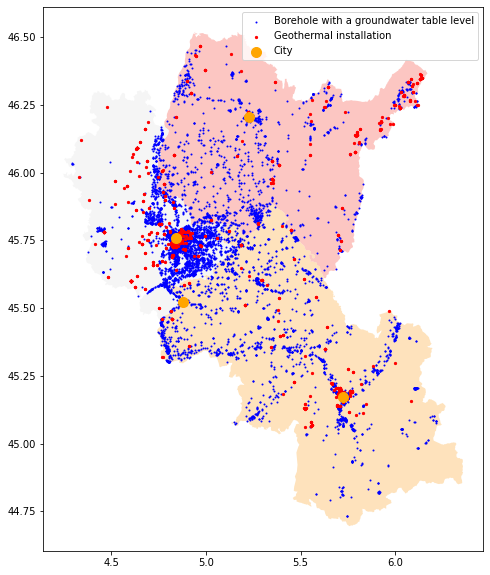

In [19]:
# We create a new geodataframe with points where we know a groundwater table depth
geo_ww = geo_bss.loc[(geo_bss['point_eau'] == 'OUI') & (geo_bss['prof_eau_sol'].notna())]

# We only keep relevent features
geo_ww = geo_ww[['ID_BSS', 'code_bss', 'z_sol', 'z_bdalti','prof_investigation',
                 'prof_eau_sol', 'geometry']]
                 
# We create a new geodataframe with points where a geotehrmal activity is known
geoth_points = geo_bss.loc[geo_bss['categorie_geothermie'].notna() |
                    geo_bss['procede_geothermique'].notna() |
                    geo_bss['usage_geothermie'].notna()]

# We plot the result
fig, ax = plt.subplots(figsize=(10,10))

# We plot our deps of interest with the Pastel 1 colormap
dep.plot(ax = ax, column = "num", cmap = "Pastel1", alpha = 0.75)

# We add the location of borehole with water level in blue
geo_ww.plot(ax =ax, color = "blue", markersize=1, label = "Borehole with a groundwater table level")

# We add the location of geothermal installations in red
geoth_points.plot(ax =ax, color = "red", markersize=5, label = "Geothermal installation")


# We add some cities to our map
main_cities.plot(ax =ax, color = "orange", marker = 'o', markersize=100, label = 'City')

plt.legend()
plt.show()

### Describing groundwater table elevation

Now that we know where groundwater bodies are located, we might want to describe groundwater levels and maybe describe gorundwater flow directions.

To do so, we refine a location of interest by choosing the coordinate of a point, we also define a relevent buffer zone around this point to reduce our dataset to this area of interest. In our example, we select the city of Lyon, and a buffer zone of 10km.

**Please note that groundwater table elevation fluctuate over time. In the following, the calculated value represents the water table elevation observed when the borehole was drilled. Also, it should be noted that the calculated values are not synchronous which can alter the local representativity regarding the interpretation groundwater flow directions and flow systems.**

*Please note that we could instead import the polygon shapefile of our choice and select boreholes inside our polygon.* 

In [20]:
# we define the long./lat. of our location of interest
site_lon, site_lat = 4.8400, 45.7600 

site = pd.DataFrame({'Name': ['Lyon'],
                     'lat': [site_lat],
                     'lon': [site_lon]})

In [21]:
# We then build a geopandas dataframe to create our buffer zone:
buff_zone = gpd.GeoDataFrame(site, geometry = gpd.points_from_xy(site.lon, site.lat), 
                          crs = "epsg:4326")

In [22]:
# to apply a buffer zone, we need to change our projeciton system to work in a metric system.
# In France, the common metric projection system is "epsg:2154"

buff_zone = buff_zone.to_crs("epsg:2154")

In [23]:
# we create our buffer zone of 10km:
buff_zone["geometry"] = buff_zone["geometry"].buffer(10000)

In [24]:
# We get back into epsg:4326 once our buffer zone is defined
buff4326 = buff_zone.to_crs("epsg:4326")
buff4326 = buff4326[['geometry']]

In [25]:
#We finally keep water wells informations located inside this studied area
geo_ww = gpd.sjoin(geo_ww, buff4326, op='within')

In [26]:
geo_ww = geo_ww[['ID_BSS', 'code_bss', 'z_sol', 'z_bdalti','prof_investigation',
                 'prof_eau_sol', 'geometry']]

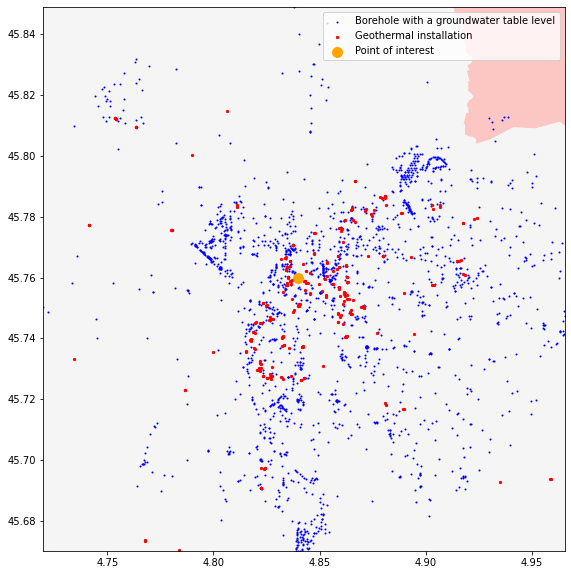

In [27]:
# We plot the result
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim((min(geo_ww['geometry'].x), max(geo_ww['geometry'].x)))
ax.set_ylim((min(geo_ww['geometry'].y), max(geo_ww['geometry'].y)))

# We plot our deps of interest with the Pastel 1 colormap
dep.plot(ax = ax, column = "num", cmap = "Pastel1", alpha = 0.75)

# We add the location of borehole with water level in blue
geo_ww.plot(ax =ax, color = "blue", markersize=1, label = "Borehole with a groundwater table level")

# We add the location of geothermal installations in red
geoth_points.plot(ax =ax, color = "red", markersize=5, label = "Geothermal installation")

# We add our city of interest
ax.scatter(site_lon, site_lat, color = "orange", marker = 'o', s=100, label = 'Point of interest')

plt.legend()
plt.show()

Now let's describe data inside our geodataframe:

In [28]:
# First we convert all interesting fields to numeric values
for col in ['z_sol', 'z_bdalti', 'prof_investigation', 'prof_eau_sol']:
    geo_ww[col] = pd.to_numeric(geo_ww[col])

# Then we can describe our geodataframe
geo_ww.describe()

,z_sol,z_bdalti,prof_investigation,prof_eau_sol
count,2078.000000,1861.000000,2006.000000,2090.000000
mean,175.863449,181.919936,19.688265,8.025206
std,78.692861,30.308797,13.990751,6.132296
min,-999.000000,155.000000,2.300000,0.200000
25%,166.800000,167.000000,12.000000,4.270000
50%,169.945000,170.000000,17.500000,6.100000
75%,182.000000,184.000000,22.500000,10.000000
max,370.000000,379.000000,250.250000,85.000000


The result shows some errors regarding the ground elevation (-999 value). Consequently, let's remove data outside first and last percentiles:

In [29]:
# We select rows inside the range we want
geo_ww = geo_ww[(geo_ww.z_sol > geo_ww.z_sol.quantile(0.01)) &
                (geo_ww.z_sol < geo_ww.z_sol.quantile(0.99))]

# Then we can describe our new geodataframe
geo_ww.describe()

,z_sol,z_bdalti,prof_investigation,prof_eau_sol
count,2036.000000,1827.000000,1953.000000,2036.000000
mean,178.907881,180.036672,19.775622,8.048355
std,23.567719,24.348494,14.110730,6.157885
min,157.044000,155.000000,2.300000,0.200000
25%,166.900000,167.000000,12.000000,4.300000
50%,169.945000,170.000000,17.500000,6.100000
75%,182.000000,183.000000,23.000000,10.000000
max,329.000000,330.000000,250.250000,85.000000


Now, we define the groundwater table elevation as the ground elevation minus the groundwater table depth. Because we have two different possibility to choose the ground elevation from the IGN *z_bdalti*:

In [30]:
geo_ww.loc[:, 'WT_elevation'] = geo_ww['z_bdalti'] - geo_ww['prof_eau_sol'] 
geo_ww.head()

,ID_BSS,code_bss,z_sol,z_bdalti,prof_investigation,prof_eau_sol,geometry,WT_elevation
6322,BSS001UPLN,07221X0041/MW17,229.0,229.0,30.0,26.0,POINT (4.76552 45.69801),203.0
6323,BSS001UPLP,07221X0042/MW9,223.0,223.0,37.5,34.0,POINT (4.76422 45.69163),189.0
4667,BSS001TNEB,06987J0020/P1,171.8,175.0,10.0,5.6,POINT (4.93157 45.80887),169.4
3940,BSS001TGJY,06983X0002/S,171.8,171.0,4.4,3.5,POINT (4.93117 45.81121),167.5
4008,BSS001TGNT,06983X0120/TP70,172.0,171.0,3.2,3.2,POINT (4.93583 45.81174),167.8


In addition, we can consider that in our area of interest we focus on the shallow aquifer where groundwater is flowing in the modern alluvial deposit. Consequently, let's focus on an investigation depth ranging from 10m to 30m:

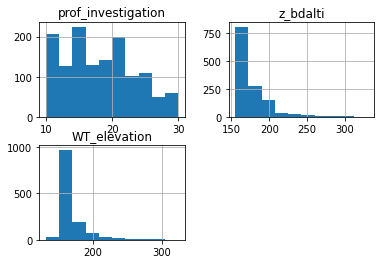

In [31]:
# We select wells with a relevant depth:
geo_ww = geo_ww[(geo_ww.prof_investigation >= 10) &
                (geo_ww.prof_investigation <= 30)]

geo_ww = geo_ww.dropna()

# We can now have a overview of different features of our dataset:
geo_ww[["prof_investigation", "z_bdalti", "WT_elevation"]].hist()
#plt.tight_layout()
plt.show()

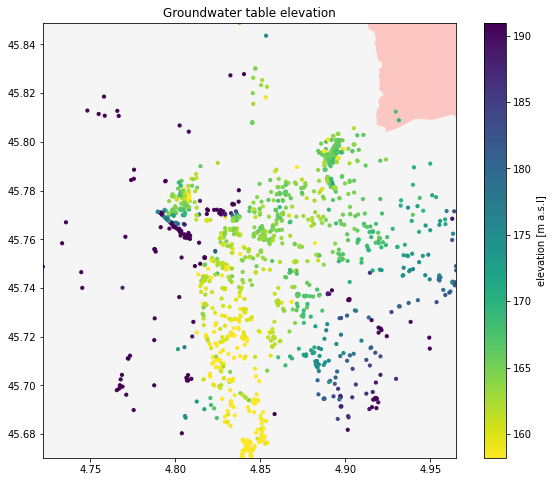

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# We plot the result
fig, ax = plt.subplots(figsize=(10,8))

ax.set_xlim((min(geo_ww['geometry'].x), max(geo_ww['geometry'].x)))
ax.set_ylim((min(geo_ww['geometry'].y), max(geo_ww['geometry'].y)))

# We plot our deps of interest with the Pastel 1 colormap
dep.plot(ax = ax, column = "num", cmap = "Pastel1", alpha = 0.75)

vmin = geo_ww["WT_elevation"].quantile(0.1)
vmax = geo_ww["WT_elevation"].quantile(0.9)

# We add the location of borehole with water level in blue
geo_ww.plot(ax = ax, cmap = "viridis_r",
            column = "WT_elevation",
            markersize=10, 
            vmin = vmin,
            vmax = vmax,
            legend = True,
            legend_kwds={'label': "elevation [m a.s.l]"})

ax.set_title("Groundwater table elevation")
plt.show()

## Interactive mapping with folium

The information above can easily be projected on an interactive map using the *folium* library. Additionnaly, it is interesting to do so because it can help us to understand the relation with geological units.

In fact, since a few years, geological tiles are available across france and can be projected and visualised using *folium*. All WMF/WFS services provided by the BRGM are listed in a table at [this page](http://geoservices.brgm.fr). It is indicated that the geological map can be visualised using the following url *http://geoservices.brgm.fr/geologie*, and the following layer *GEOLOGIE*. We directly use these input to define our WMS tile layer (see below in the script).

Then we can build our map using *folium*:

In [33]:
# We import the folium library
import folium

# We need to import branca.colormap to give pretty colors to our points according to groundwater
# table elevation
import branca.colormap as cm

# We build our map focusing on our site and specifying the zoom start
mymap = folium.Map(location=[site_lat, site_lon], 
                   zoom_start=12,
                   control_scale = True)

# Add the geological map of France
url = 'http://geoservices.brgm.fr/geologie'
layer1 = 'GEOLOGIE'
folium.WmsTileLayer(url, layer1, attr = 'BRGM', name = 'toto').add_to(mymap)
#folium.TileLayer('http://geoservices.brgm.fr/geologie/GEOLOGIE', attr = 'BRGM', name = 'toto').add_to(mymap)

# Add a feature group to add borehole with groundwater table elevation
fg_gwt = folium.FeatureGroup(name = 'Groundwater table elevation')
mymap.add_child(fg_gwt)

colormap = cm.LinearColormap(colors=['orange', 'yellow', 'green', 'lightblue', 'blue'], 
                             index=[geo_ww["WT_elevation"].quantile(0.1),
                                    geo_ww["WT_elevation"].quantile(0.25),
                                    geo_ww["WT_elevation"].quantile(0.5),
                                    geo_ww["WT_elevation"].quantile(0.75),
                                    geo_ww["WT_elevation"].quantile(0.9)], 
                             vmin=geo_ww["WT_elevation"].quantile(0.1),
                             vmax=geo_ww["WT_elevation"].quantile(0.9))

# We add the caption of our colormap
colormap.caption = 'Groundwater table elevation [m asl]'

# We give an explicit description of longitude and latitude of our points:
geo_ww['lon'] = geo_ww['geometry'].x
geo_ww['lat'] = geo_ww['geometry'].y

#before interating over our dataset we reset its index
#geo_ww = geo_ww.reset_index()
# We add all points of our dataset
for i, h in zip(geo_ww.index.values, geo_ww.WT_elevation.values):
    dfi = folium.CircleMarker(
        location = [geo_ww.at[i,'lat'], geo_ww.at[i,'lon']],
        popup =str(round(h,2)) + " m asl",
        radius= 7,
        fill=True,
        fill_opacity=0.7,
        color = colormap(h),
        fill_color = colormap(h))
    dfi.add_to(fg_gwt)

mymap.add_child(colormap)
mymap.add_child(folium.map.LayerControl(collapsed=True))

Of couse we can save this map in *html* and open it later with any navigator:

In [ ]:
mymap.save("my_Python_for_Geosciences_map.html")

## Access to hydraulic head monitoring data

Since a couple of years, several APIs dedicated to water management have been developped on a national platfrom called [Hubeau](https://hubeau.eaufrance.fr/page/apis). Some of these APIs are dedicated to hydrobiology and surface water monitoring, and others to quantitative and qualitative description of groundwater.

The principle is quite easy: you provide the API of your choice with (1) one or several borehole identifiers, (2) a period of interest, (3) some parameters of interest (piezometric level, temperature, etc.) and you get back a dictionnary with all information.

First the procedure to describe the hydraulic head fluctuation at a given borehole will be described. Secondly, we will focus on how to find all recording stations around a area of interest, for a given period of time.

### Getting hydraulic head fluctuations

Let's see how the groundwater piezometric API works. We first need define one borehole identifier *code_bss*, and a period of interest:

In [34]:
# Definition of an identifier:
mycode = "06987A0186/S"

# Definition of a period of interest:
mydate_i = "2015-01-01" #year/month/day
mydate_f = "2020-12-31" #year/month/day

To query the API, we need to build an URL which depends on previous parameters. I give the function below providing you the appropriate URL:

In [35]:
def getHubeauURL_piezo(code_bss, date_i, date_f):
    url_root = "https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?"
    url_code = "code_bss=" + code_bss.replace("/","%2F")
    url_date = "&date_debut_mesure=" + date_i + "&date_fin_mesure=" + date_f
    url_tail = "&size=20000&sort=asc"
    return url_root + url_code + url_date + url_tail

We can now call this function as follow:

In [36]:
myurl = getHubeauURL_piezo(mycode, mydate_i, mydate_f)

print(myurl)

https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/chroniques?code_bss=06987A0186%2FS&date_debut_mesure=2015-01-01&date_fin_mesure=2020-12-31&size=20000&sort=asc


You can now make our query using the *resquests.get* function:

In [37]:
# We get the content of the webpage
r = requests.get(myurl)

# The server response:
print(r)

<Response [200]>


The code '200' means that our query is successful (the code is valid and there are some data available). Let's organize the result (using the *json* method) and print the content of the webpage using the following procedure:

In [ ]:
# We organize the content into a json dictionnary
res = r.json()

# We print the result
res

The resulting content is a dictionnary organided according to the date of measurements. We now need to define a function to extract the information we want in this dictionnary. The first key of this dictionnary gives us a *count* of all measurements over our period of interest. All piezometric values are stored in a *data* sub-dictionnary. Let's see on the first element of the *data* dictionnary:

In [39]:
res['data'][0]

{'code_bss': '06987A0186/S',
 'code_continuite': '2',
 'code_nature_mesure': None,
 'code_producteur': '196',
 'date_mesure': '2015-01-01',
 'mode_obtention': 'Valeur mesurée',
 'niveau_nappe_eau': 163.09,
 'nom_continuite': 'Point lié au point précédent',
 'nom_nature_mesure': None,
 'nom_producteur': 'Service Géologique Régional Rhône-Alpes (196)',
 'profondeur_nappe': 5.41,
 'qualification': 'Correcte',
 'statut': 'Donnée contrôlée niveau 2',
 'timestamp_mesure': 1420117200000,
 'urn_bss': 'http://services.ades.eaufrance.fr/pointeau/06987A0186/S'}

We have here a new dictionnary with the ID of our borehole, the date of the measurement (*date_mesure*), the associated timestamp (*timestamp_mesure*), the hydraulic head measured (*niveau_nappe_eau*) and other informations.

We can make a function to convert this dictionnary into a dataframe keeping only relevant features as follow: 

In [40]:
def piezoDico_to_pandas_df(res):
    # We convert the data into a dataframe
    df = pd.DataFrame.from_dict(res["data"])

    # We only keep relevant columns
    df = df[['date_mesure', 'niveau_nappe_eau']]

    # We rename columns
    df = df.rename(columns = {'date_mesure':'date',
                    'niveau_nappe_eau': 'hydraulic_head'})

    # We make sure that the hydraulic head is numeric
    df['hydraulic_head'] = pd.to_numeric(df['hydraulic_head'])

    # We convert the date as a datetime format and we define it as index
    df['date'] = pd.to_datetime(df['date'], format =  "%Y-%m-%d")
    df = df.set_index("date").to_period('d')
    return df

df = piezoDico_to_pandas_df(res)
df.head()

,hydraulic_head
date,
2015-01-01,163.09
2015-01-02,163.08
2015-01-03,163.07
2015-01-04,163.06
2015-01-05,163.19


We can finally plot the hydraulic head fluctuation:

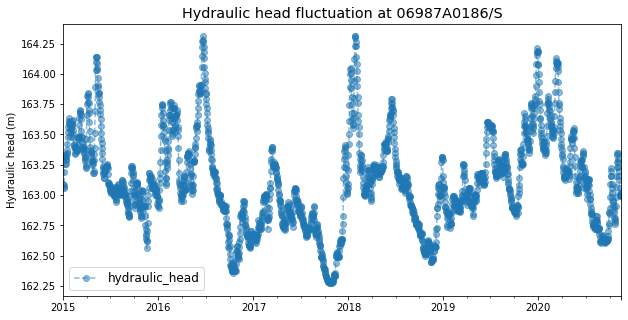

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
plt.rcParams.update({'font.size': 12})

ax.set_title('Hydraulic head fluctuation at ' + mycode)

# We plot the mean hydraulic head over the period
df['hydraulic_head'].plot(ax = ax, 
              marker='o', 
              alpha=0.5,
              linestyle='--')

ax.set_ylabel('Hydraulic head (m)')
ax.set_xlabel('')

plt.legend()
plt.show()

### Finding piezometric monitoring stations around a location of interest

A procedure exists to find all stations with hydraulic head records around a location of interest. What you need is to define the longitude and latitude coordinates of a rectangle area. Let's take the smallest rectangle including our previous circular buffer zone:

In [42]:
# We define our rectangle of interest:
rect = gpd.GeoDataFrame(geometry = buff4326.envelope)

# We take put the coordinates into a list:
pnts = np.dstack(rect.at[0, 'geometry'].boundary.xy)
pnts

array([[[ 4.71138049, 45.66997581],
        [ 4.96860974, 45.66997581],
        [ 4.96860974, 45.85002454],
        [ 4.71138049, 45.85002454],
        [ 4.71138049, 45.66997581]]])

To make our query, we only need the lower left and top right corners coordinates:

In [43]:
llc = pnts[0][0]
trc = pnts[0][2]

We then need to make a new function to produce the URL and an other one to organize the result in a pandas dataframe:

In [44]:
def getHubeauURLstations(param, date_recherche, llc, trc):
    #param is "piezo" or "quality"
    if param == "piezo":
        url_root = "https://hubeau.eaufrance.fr/api/v1/niveaux_nappes/stations?"
    elif param == "quality":
        url_root = "https://hubeau.eaufrance.fr/api/v1/qualite_nappes/stations?"
    else:
        return print("error with param")
        
    llc_x, llc_y = str(round(llc[0],4)), str(round(llc[1],4))
    trc_x, trc_y = str(round(trc[0],4)), str(round(trc[1],4))
    
    url_bbox = "bbox=" + llc_x + "%2C" + llc_y + "%2C" + trc_x + "%2C" + trc_y
    url_date = "&date_recherche=" + date_recherche
    url_tail = "&format=json&size=20000"
    return url_root + url_bbox + url_date + url_tail

def StationsToDF(url):
    # We get the content of the webpage
    r = requests.get(url)
    # We organize the content into a json dictionnary
    res = r.json()
    # We convert the data into a dataframe
    df = pd.DataFrame.from_dict(res["data"])
    return df

Let's run this function to sew how many piezometric stations are working/recording at a given date: the 1st of january 2020.

In [ ]:
new_url = getHubeauURLstations("piezo", "2020-01-01", llc, trc)
stations = StationsToDF(new_url)

stations = stations.set_index("code_bss")
stations

We can of course print the location of these active stations on an interactive folium map:

In [46]:
# We import the folium library
import folium

# We build our map focusing on our site and specifying the zoom start
mymap = folium.Map(location=[site_lat, site_lon], 
                   zoom_start=11,
                   show=True, control_scale = True,
                   width = 400)

# Add the geological map of France
url = 'http://geoservices.brgm.fr/geologie'
layer1 = 'GEOLOGIE'
folium.WmsTileLayer(url, layer1, attr = 'BRGM', name = 'Geological map', show=True).add_to(mymap)

# Add a feature group to add borehole with active piezometric stations
fg_pz = folium.FeatureGroup(name = 'Active piezometric stations', show = True)
mymap.add_child(fg_pz)

# We add all points of our dataset
for code_bss in stations.index.values:
    pzi = folium.Marker(
        location = [stations.at[code_bss,'y'], stations.at[code_bss,'x']],
        popup = str(code_bss))
    pzi.add_to(fg_pz)

mymap.add_child(folium.map.LayerControl(collapsed=True))

Now, we can plot the piezometric levels of these stations over the similar period of interest that we defined earlier.

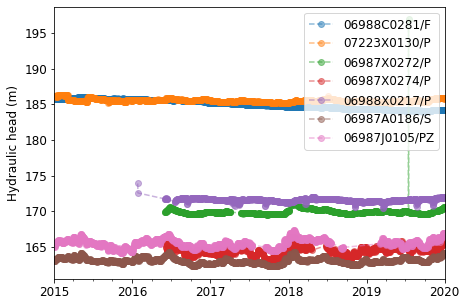

In [47]:
# Definition of a period of interest:
mydate_i = "2015-01-01" #year/month/day
mydate_f = "2020-01-01" #year/month/day

fig, ax = plt.subplots(figsize=(7,5))
plt.rcParams.update({'font.size': 12})

for code in stations.index:
    myurl = getHubeauURL_piezo(code, mydate_i, mydate_f)
    r = requests.get(myurl)
    res = r.json()
    df = piezoDico_to_pandas_df(res)
    

    # We plot the mean hydraulic head over the period
    df['hydraulic_head'].plot(ax = ax, 
                  marker='o', 
                  alpha=0.5,
                  linestyle='--',
                  label = code)

ax.set_ylabel('Hydraulic head (m)')
ax.set_xlabel('')

plt.legend()
plt.show()

## Access to physico-chemical parameters

Similarly, we can make some queries to observe the fluctuation of some physico-chemical parameters such as groundwater temperature, nitrates concentrations, pesticides... many other parameters are availble.

### Exploration of accessible physico-chemical parameters

Since 1992, the French producers of public water data have engaged a consistency process for their data in the framework of the French water information system. Consequently, all groundwater quality parameters are associated to a number in a referetial SANDRE.

This referential can be download below. We can see that 1845 parameters are available.

In [48]:
url_root= "http://www.sandre.eaufrance.fr/sites/default/files/document-sandre/"
file = "correspondance_par_sise_sandre_18092018.xls"
url = url_root + file

r = requests.get(url)

open(file, 'wb').write(r.content)
sandre = pd.ExcelFile(file).parse(0)
new_header = sandre.iloc[0]
sandre = sandre[1:]
sandre.columns = new_header
sandre = sandre[['Nom_famille_sise', 'nom_parametre_sise', 'code_parametre_sandre']]

sandre

,Nom_famille_sise,nom_parametre_sise,code_parametre_sandre
1,COMPOSES ORGANOHALOGENES VOLATILS,"Tétrachloroéthane-1,1,1,2",1270
2,COMPOSES ORGANOHALOGENES VOLATILS,"1,1,1,2 Tétrachloropropane",2704
3,COMPOSES ORGANOHALOGENES VOLATILS,"1,1,1,3 Tétrachloropropane",2705
4,COMPOSES ORGANOHALOGENES VOLATILS,"Trichloroéthane-1,1,1",1284
5,COMPOSES ORGANOHALOGENES VOLATILS,"Tétrachloroéthane-1,1,2,2",1271
...,...,...,...
1841,PHYTOPLANCTONS,% de colo de ulothricophyc. subst,6431
1842,PHYTOPLANCTONS,Colonies de zygophyc. substrat,6432
1843,PHYTOPLANCTONS,% de colo de zygophyc. substr,6432
1844,PARAMETRES MICROBIOLOGIQUES,Entérocoques / 100 mL (qPCR),6455


We could explore all accessible parameters, but in this tutorial we focus on two of them:
- temperature with the code 1301,
- nitrates concentration with the code 1340.

It can be check by printing the appropriate lines of the dataframe:

In [49]:
sandre.loc[(sandre.code_parametre_sandre == 1301) |
           (sandre.code_parametre_sandre == 1340)]

,Nom_famille_sise,nom_parametre_sise,code_parametre_sandre
1255,PARAMETRES AZOTES ET PHOSPHORES,Nitrates (en NO3),1340
1645,CONTEXTE ENVIRONNEMENTAL,Température de l'eau,1301


The information about these parameters (units, etc.) are described in the following webpages (in french):
- [Nitrates - SANDRE](http://www.sandre.eaufrance.fr/urn.php?urn=urn:sandre:donnees:PAR:FRA:code:1340:::referentiel:2:html)
- [Temperature - SANDRE](http://www.sandre.eaufrance.fr/urn.php?urn=urn:sandre:donnees:PAR:FRA:code:1301:::referentiel:2:html)

You can easly access and get the information about the parameter you want by using the following function depending on the parameter code:

In [50]:
def getSandreURL(code_param):
    """
    This function prints the SANDRE information associated to the code (input)
    """
    url_head = "http://www.sandre.eaufrance.fr/urn.php?urn=urn:sandre:donnees:PAR:FRA:code:"
    code_param = str(code_param)
    url_tail = ":::referentiel:2:html"
    url = url_head + code_param + url_tail
    print(url)
    
# Example:
getSandreURL(1301)

http://www.sandre.eaufrance.fr/urn.php?urn=urn:sandre:donnees:PAR:FRA:code:1301:::referentiel:2:html


These codes must be specified when making queries with the different APIs.

### Finding quality monitoring stations around a location of interest

First, let's find some quality monitoring stations around our location of interest by using the function defined ealier:

In [60]:
q_url = getHubeauURLstations("quality", "2020-01-01", llc, trc)
q_stations = StationsToDF(q_url)
q_stations.head()

,bss_id,code_bss,urn_bss,date_debut_mesure,date_fin_mesure,precision_coordonnees,longitude,latitude,altitude,code_insee,nom_commune,num_departement,nom_departement,nom_region,circonscriptions_administrative_bassin,bassin_dce,urn_bassin_dce,code_nature_pe,nom_nature_pe,uri_nature_pe,libelle_pe,code_caracteristique_aquifere,nom_caracteristique_aquifere,uri_caracteristique_aquifere,code_etat_pe,nom_etat_pe,uri_etat_pe,code_mode_gisement,nom_mode_gisement,uri_mode_gisement,profondeur_investigation,commentaire_pe,codes_entite_hg_bdlisa,noms_entite_hg_bdlisa,urns_bdlisa,codes_masse_eau_rap,noms_masse_eau_rap,urns_masse_eau_rap,codes_masse_eau_edl,noms_masse_eau_edl,urns_masse_eau_edl,codes_reseau,noms_reseau,uris_reseau,geometry
0,BSS001TLEA,06986T0059/S7,http://services.ades.eaufrance.fr/pointeau/BSS...,2004-02-05,2004-02-05,None,4.840702,45.731292,168.0,69387,Lyon 7e Arrondissement,69,Rhône,Auvergne-Rhône-Alpes,None,None,None,12,Puits,http://id.eaufrance.fr/NSA/149#12,Puits S7 Montage,None,None,None,3.0,Opérationnel,http://id.eaufrance.fr/NSA/146#3,1.0,Libre,http://id.eaufrance.fr/NSA/81#1,16.0,None,[712AG06],[Alluvions en rive gauche du Rhône entre la co...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG325],[Alluvions du Rhône entre le confluent de la S...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,None,None,[],"[0600000137, 0000000075]",[Réseau qualitatif des eaux souterraines pour ...,"[http://id.eaufrance.fr/DC/0600000137, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
1,BSS001TPEA,06987X0252/PZ4,http://services.ades.eaufrance.fr/pointeau/BSS...,2002-10-14,2004-06-02,None,4.875022,45.762547,168.0,69266,Villeurbanne,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,6,Forage,http://id.eaufrance.fr/NSA/149#6,None,None,None,None,3.0,Opérationnel,http://id.eaufrance.fr/NSA/146#3,1.0,Libre,http://id.eaufrance.fr/NSA/81#1,6.0,None,[712AG06],[Alluvions en rive gauche du Rhône entre la co...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG325],[Alluvions du Rhône entre le confluent de la S...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,None,None,[],"[0600000137, 0000000075]",[Réseau qualitatif des eaux souterraines pour ...,"[http://id.eaufrance.fr/DC/0600000137, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
2,BSS001TPFA,06987X0276/PZ2,http://services.ades.eaufrance.fr/pointeau/BSS...,2003-10-31,2004-10-04,None,4.869878,45.750762,170.0,69123,Lyon,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,6,Forage,http://id.eaufrance.fr/NSA/149#6,None,None,None,None,3.0,Opérationnel,http://id.eaufrance.fr/NSA/146#3,NaN,None,None,11.0,None,[712AG06],[Alluvions en rive gauche du Rhône entre la co...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG325],[Alluvions du Rhône entre le confluent de la S...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,None,None,[],"[0600000137, 0000000075]",[Réseau qualitatif des eaux souterraines pour ...,"[http://id.eaufrance.fr/DC/0600000137, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
3,BSS001URFA,07222X0490/PN4,http://services.ades.eaufrance.fr/pointeau/BSS...,2000-11-27,2007-12-12,None,4.845675,45.692831,164.0,69199,Saint-Fons,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,6,Forage,http://id.eaufrance.fr/NSA/149#6,None,None,None,None,0.0,Etat Inconnu,http://id.eaufrance.fr/NSA/146#0,NaN,None,None,16.0,None,[712AG06],[Alluvions en rive gauche du Rhône entre la co...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG325],[Alluvions du Rhône entre le confluent de la S...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,None,None,[],"[0600000137, 0000000075]",[Réseau qualitatif des eaux souterraines pour ...,"[http://id.eaufrance

We can see that there is 471 stations. However, the dates are not necessarily matching our query (it is probably a issue that will be solved in a future version of the API). To refine our selection on our period of interest we convert all date features in datetimes format and compare with our datetimes of interest:

In [61]:
from datetime import datetime

q_stations['date_debut_mesure'] = pd.to_datetime(q_stations['date_debut_mesure'], format =  "%Y-%m-%d")
q_stations['date_fin_mesure'] = pd.to_datetime(q_stations['date_fin_mesure'], format =  "%Y-%m-%d")

datetime_i = datetime.strptime(mydate_i, "%Y-%m-%d")
datetime_f = datetime.strptime(mydate_f, "%Y-%m-%d")

q_stations = q_stations.loc[(q_stations['date_debut_mesure'] <= datetime_i) &
                            (q_stations['date_fin_mesure'] >= datetime_f)]

q_stations = q_stations.set_index("code_bss")
q_stations .head()       

,bss_id,urn_bss,date_debut_mesure,date_fin_mesure,precision_coordonnees,longitude,latitude,altitude,code_insee,nom_commune,num_departement,nom_departement,nom_region,circonscriptions_administrative_bassin,bassin_dce,urn_bassin_dce,code_nature_pe,nom_nature_pe,uri_nature_pe,libelle_pe,code_caracteristique_aquifere,nom_caracteristique_aquifere,uri_caracteristique_aquifere,code_etat_pe,nom_etat_pe,uri_etat_pe,code_mode_gisement,nom_mode_gisement,uri_mode_gisement,profondeur_investigation,commentaire_pe,codes_entite_hg_bdlisa,noms_entite_hg_bdlisa,urns_bdlisa,codes_masse_eau_rap,noms_masse_eau_rap,urns_masse_eau_rap,codes_masse_eau_edl,noms_masse_eau_edl,urns_masse_eau_edl,codes_reseau,noms_reseau,uris_reseau,geometry
code_bss,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
07222X0396/F,BSS001URBC,http://services.ades.eaufrance.fr/pointeau/BSS...,2008-03-26,2020-07-07,None,4.834449,45.719531,164.0,69123,Lyon,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,6,Forage,http://id.eaufrance.fr/NSA/149#6,PIEZOMETRE PRIVE,None,None,None,0.0,Etat Inconnu,http://id.eaufrance.fr/NSA/146#0,1.0,Libre,http://id.eaufrance.fr/NSA/81#1,NaN,None,[712AG06],[Alluvions en rive gauche du Rhône entre la co...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG325],[Alluvions du Rhône entre le confluent de la S...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,[DG384],[Alluvions du Rhône agglomération lyonnaise et...,[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,"[0600000237, 0000000030, 0000000072, 0600000005]",[Contrôles opérationnels de l'état chimique de...,"[http://id.eaufrance.fr/DC/0600000237, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
06988X0215/P,BSS001TQGH,http://services.ades.eaufrance.fr/pointeau/BSS...,2004-07-12,2020-06-30,None,4.959522,45.741882,200.0,69271,Chassieu,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,12,Puits,http://id.eaufrance.fr/NSA/149#12,PUITS PRIVE DU GOLF,None,None,None,3.0,Opérationnel,http://id.eaufrance.fr/NSA/146#3,1.0,Libre,http://id.eaufrance.fr/NSA/81#1,NaN,None,[040AJ53],[Alluvions fluvio-glaciaires wurmiennes (code ...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG334],"[Couloirs de l'Est lyonnais (Meyzieu, Décines,...",[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,[DG334],"[Couloirs de l'Est lyonnais (Meyzieu, Décines,...",[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,"[0600000225, 0600000237, 0600000005, 060000023...",[Réseau de suivi qualitatif de la nappe de l'e...,"[http://id.eaufrance.fr/DC/0600000225, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
06983X0137/P,BSS001TGPL,http://services.ades.eaufrance.fr/pointeau/BSS...,2008-02-14,2020-04-27,None,4.932431,45.838280,290.0,01249,Miribel,01,Ain,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les cours d'eau côtiers méditerran...,http://www.sandre.eaufrance.fr/geo/BassinDCE/FRD,12,Puits,http://id.eaufrance.fr/NSA/149#12,PUITS PRIVE AU LIEU DIT BOSSIEU,None,None,None,3.0,Opérationnel,http://id.eaufrance.fr/NSA/146#3,0.0,Mode de gisement inconnu,http://id.eaufrance.fr/NSA/81#0,NaN,None,[507AC00],[Complément de l'entité NV2 : Formations plio-...,[http://reseau.eaufrance.fr/geotraitements/bdl...,[DG135],[Formations plioquaternaires Dombes - sud],[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,[DG177],[Formations plioquaternaires Dombes],[http://www.sandre.eaufrance.fr/geo/MasseDEauS...,"[0600000237, 0000000030, 0000000072, 060000026...",[Contrôles opérationnels de l'état chimique de...,"[http://id.eaufrance.fr/DC/0600000237, http://...","{'type': 'Point', 'crs': {'type': 'name', 'pro..."
06987H0064/F,BSS001TMYQ,http://services.ades.eaufrance.fr/pointeau/BSS...,2008-03-05,2020-07-07,None,4.879186,45.776945,169.0,69266,Villeurbanne,69,Rhône,Auvergne-Rhône-Alpes,[Rhône-Méditerranée],Le Rhône et les co

We see that we have finally 7 active stations and we can add them (red color) to our interactive map:

In [53]:
# We build our map focusing on our site and specifying the zoom start
mymap = folium.Map(location=[site_lat, site_lon], 
                   zoom_start=11,
                   show=True, control_scale = True,
                   width = 400)

# Add the geological map of France
url = 'http://geoservices.brgm.fr/geologie'
layer1 = 'GEOLOGIE'
folium.WmsTileLayer(url, layer1, attr = 'BRGM', name = 'Geological map', show=True).add_to(mymap)

# Add a feature group to add borehole with active quality stations
fg_quality = folium.FeatureGroup(name = 'Active groundwater quality stations', show = True)
mymap.add_child(fg_quality)

# We add all points of our quality dataset
for code_bss in q_stations.index.values:
    qi = folium.Marker(
        location = [q_stations.at[code_bss,'latitude'], q_stations.at[code_bss,'longitude']],
        popup = str(code_bss),
        icon=folium.Icon(color='red', icon='info-sign'))
    qi.add_to(fg_quality)
    
# Add a feature group to add borehole with active piezometric stations
fg_pz = folium.FeatureGroup(name = 'Active piezometric stations', show = True)
mymap.add_child(fg_pz)

# We add all points of our dataset
for code_bss in stations.index.values:
    pzi = folium.Marker(
        location = [stations.at[code_bss,'y'], stations.at[code_bss,'x']],
        popup = str(code_bss))
    pzi.add_to(fg_pz)

mymap.add_child(folium.map.LayerControl(collapsed=True))

### Getting groundwater temperature and nitrates concentrations in a water well

We first need define one borehole identifier code_bss, a period of interest and the code of parameters we want to explore (temperature and nitrates in our example):

In [54]:
# Definition of an identifier:
code_ex = "08036X1858/F2"

# Definition of a period of interest:
date_initial_ex = "2017-01-01" #year/month/day
date_final_ex = "2019-12-31" #year/month/day

params_ex = [1301, 1340] #our parameters in a list

To query the API, we need to build an URL which depends on previous parameters. I give the function below providing you the appropriate URL:

In [55]:
def getHubeauURLquality(code, date_initial, date_final, params):
    """
    this function return the url needed to get the required parameters
    of the borehole code
    """
    url_head = "https://hubeau.eaufrance.fr/api/v1/qualite_nappes/analyses?"
    url_code = "bss_id=" + str(code).replace("/","%2F")
    url_params = "&code_param=" 
    for par in params:
        url_params += str(par) + "%2C%20"
        
    url_params = url_params[:-6]
    url_date = "&date_debut_prelevement=" + date_initial + "&date_fin_prelevement=" + date_final
    url_end = "&size=20000&sort=asc"
    
    url = url_head + url_code + url_params + url_date + url_end

    return url

We can now call this function as follow:

In [56]:
url_ex = getHubeauURLquality(code_ex, date_initial_ex, date_final_ex, params_ex)

print(url_ex)

https://hubeau.eaufrance.fr/api/v1/qualite_nappes/analyses?bss_id=08036X1858%2FF2&code_param=1301%2C%201340&date_debut_prelevement=2017-01-01&date_fin_prelevement=2019-12-31&size=20000&sort=asc


Now, we get and organize the content of this webpage into a pandas dataframe. Please note that a very large number of features are available. You can explore these features by visiting the [API website](https://hubeau.eaufrance.fr/) or by removing the last command in the following cell. 

Here we only keep following features:
- the date of the measurement,
- the code of the parameter measured,
- the name of the parameter measured (in french),
- the resulting value,
- the quantification limit,
- the detection limit,
- the analytical uncertainty

Finally we print the ten first lines of our dataset.

In [57]:
r = requests.get(url_ex)
res = r.json()
df = pd.DataFrame.from_dict(res["data"])

df = df.rename(columns={"date_debut_prelevement":"date",
                        "resultat": "value"})

df = df[['date', 'code_param', 'nom_param', 'value',
         'limite_quantification','limite_detection', 'incertitude_analytique']]

# We explicitly define the date in a datetime format
df['date'] = pd.to_datetime(df['date'], format =  "%Y-%m-%d")
df = df.set_index("date")
df.head(10)

,code_param,nom_param,value,limite_quantification,limite_detection,incertitude_analytique
date,,,,,,
2017-05-11,1340,Nitrates,19.0,0.10,None,None
2017-12-07,1340,Nitrates,19.0,0.10,None,None
2017-12-07,1301,Température de l'Eau,16.7,NaN,None,None
2018-07-05,1340,Nitrates,17.5,0.10,None,None
2018-07-05,1301,Température de l'Eau,17.0,NaN,None,None
2018-10-16,1301,Température de l'Eau,17.0,NaN,None,None
2018-10-16,1340,Nitrates,17.9,0.10,None,None
2019-05-21,1301,Température de l'Eau,17.0,NaN,None,None
2019-05-21,1340,Nitrates,20.0,0.25,None,None


We can now plot the results:

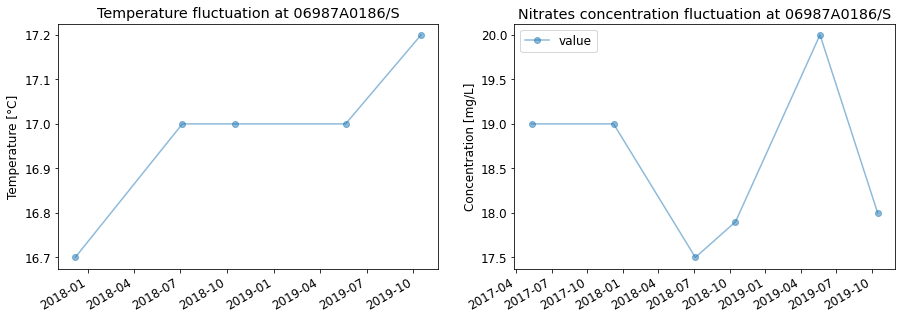

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.rcParams.update({'font.size': 12})
ax = axs[0]
ax.set_title('Temperature fluctuation at ' + mycode)

# We plot the temperature fluctuation over the period
df.loc[df.code_param == 1301]['value'].plot(ax = ax, 
              marker='o', 
              alpha=0.5)

ax.set_ylabel('Temperature [°C]')
ax.set_xlabel('')

ax = axs[1]
ax.set_title('Nitrates concentration fluctuation at ' + mycode)

# We plot the nitrates fluctuation over the period
df.loc[df.code_param == 1340]['value'].plot(ax = ax, 
              marker='o', 
              alpha=0.5)

ax.set_ylabel('Concentration [mg/L]')
ax.set_xlabel('')

plt.legend()
plt.show()

## Discussion

This notebook intends to introduce some APIs and geo-webservices dedicated to the (hydro-)geological knowledge of France. This notebook has been reviewed and successfuly returns several parameter descriptions around an area of interest. Please note that all input data have been carefully checked, and be aware that an alteration of input data might raise errors and/or inconsistencies. Particularly, some site-specific choices have been made to illustrate different possibilities, and must not be generalized to other locations.

Of course, readers are invited to play with all input parameters, and focus on other locations, but following advises and comments are given:
- the area of interest should be carefully determined and must be of a reasonnable size to limit the execution time of different procedures. Particularly, lauching a data extraction of the all France is disadvised,
- the closeness and depth of boreholes must be taken carefully when comparing some measurements: un-correlated fluctuations can be observed when sensors are note located into the same groundwater body or geological unit, even if boreholes are close.
- there are many more available API functionnalities not discussed in this notebook. Please visit [Hubeau](https://hubeau.eaufrance.fr/) and [PIC'EAU](https://piceau.brgm.fr/) to find out more.
- to work at reginal scales on several stations at a time, there are more efficient methods to extract and analyse data than ones presented in this notebook.